In [1]:
import tensorflow as tf
from functools import partial
from tensorflow.keras.layers import Conv2D, Dense, Flatten, InputLayer, Reshape
from alibi_detect.cd.tensorflow import preprocess_drift
from alibi_detect.cd import MMDDriftOnline
import numpy as np
import methods
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from ood_metrics import calc_metrics, plot_roc, plot_pr, plot_barcode

import logging 
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
# Assume that you have 12GB of GPU memory and want to allocate ~4GB:
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.1)

sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

Num GPUs Available:  1


In [2]:
from torchvision.utils import make_grid
from torchvision.io import read_image
import torchvision.transforms.functional as F
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torchsummary import summary

%matplotlib inline
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [3]:
def test_mmd(cd, imgs_ref, imgs, label):
    test_stats = []
    labels = []
    imgs_array = []
    for img in imgs:
        pred = cd.predict(x_t=img)
        cd.reset()
        test_stats.append(pred['data']['test_stat'])
        labels.append(label)
        imgs_array.append(img)
    d = {"test_stats": test_stats, "labels": labels, "imgs_array": imgs_array}

    df = pd.DataFrame(data=d)
    return df

In [4]:
inlier_names = ["cCry", "sCry", "uCry", "hCast", "nhCast", "nsEC", "sEC", "WBC", "RBC", "Artifact", "Dirt", "LD"]
testImages_cCry = methods.getTestRawImages("cCry", (32,32))
testImages_sCry = methods.getTestRawImages("sCry", (32,32))
testImages_uCry = methods.getTestRawImages("uCry", (32,32))
testImages_hCast = methods.getTestRawImages("hCast", (32,32))
testImages_nhCast = methods.getTestRawImages("nhCast", (32,32))
testImages_nsEC = methods.getTestRawImages("nsEC", (32,32))
testImages_sEC = methods.getTestRawImages("sEC", (32,32))
testImages_WBC = methods.getTestRawImages("WBC", (32,32))
testImages_RBC = methods.getTestRawImages("RBC", (32,32))
testImages_Artifact = methods.getTestRawImages("Artifact", (32,32))
testImages_Dirt = methods.getTestRawImages("Dirt", (32,32))
testImages_LD = methods.getTestRawImages("LD", (32,32))
testImages_condensation = methods.getTestRawImages("condensation", (32,32))

X_inliers = np.concatenate((testImages_cCry, testImages_sCry, testImages_uCry, testImages_hCast, testImages_nhCast, testImages_nsEC,
                       testImages_sEC, testImages_WBC, testImages_RBC))
unclassified_imgs = methods.getTestRawImages("Unclassified", (32,32))

In [5]:
encoding_dim = 256
encoder_net = tf.keras.Sequential(
  [
      InputLayer(input_shape=(32, 32, 1)),
      Conv2D(64, 3, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(128, 3, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(512, 3, strides=2, padding='same', activation=tf.nn.relu),
      Flatten(),
      Dense(encoding_dim,)
  ]
)
encoder_net.summary()
# define preprocessing function
preprocess_fn = partial(preprocess_drift, model=encoder_net, batch_size=64)

# initialise drift detector
ERT = 100  # expected run-time in absence of change
W = 20  # size of test window
cd = MMDDriftOnline(X_inliers, ERT, W, backend='tensorflow', preprocess_fn=preprocess_fn, n_bootstraps = 10000)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 512)         590336    
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
Total params: 2,762,240
Trainable params: 2,762,240
Non-trainable params: 0
_________________________________________________________________


  1%|          | 63/10000 [00:00<00:15, 627.50it/s]

Generating permutations of kernel matrix..


Computing thresholds: 100%|██████████| 20/20 [03:54<00:00, 11.71s/it]


In [6]:
df_unclassified = test_mmd(cd, X_inliers, unclassified_imgs, 0)

In [7]:
sorted_test_stats = df_unclassified.sort_values(by=['test_stats'])

<AxesSubplot:xlabel='labels', ylabel='test_stats'>

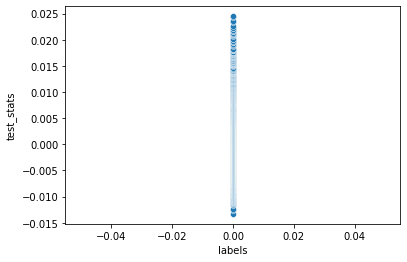

In [10]:
sns.scatterplot(data=sorted_test_stats, x = "labels", y="test_stats")